# AIM
- Re-run feature selection with tsfresh with revised preprocessing routine as of Mar22

Created: 23 Mar 2022

# LIBRARIES

In [2]:
##### MODULES
import os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib.dates
import matplotlib.patches
import datetime as dt
import ast

## custom modules
# import sys  
# sys.path.append('../../scripts')

import import_data
import clean_data
import mappings
import plotting
import report
import helper

##### OPTIONS
pd.options.mode.chained_assignment = None

# autoreload external modules after saving changes to disk
%reload_ext autoreload
%autoreload 2

##### DIRECTORIES
proj_dir = Path('.') / '..' / '..'
source_data_dir = proj_dir/'data'/'source'
clean_data_dir =  proj_dir/'data'/'clean'
viz_dir = proj_dir/'viz'

In [3]:
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

import random

In [4]:
import feather

# PARAMETERS

In [5]:
PATH_TO_PREPROCESSED_DATA = proj_dir/'data'/'clean'/'preprocessMar22'/'data_merge2.ftr'

SEED = 123
N_PRIMARY_KEY_SAMPLE = None # number of primary keys to sample per true/false target, None for no sampling i.e. retain all samples
HOURS_PER_NIGHT = 15 # 8pm to 10am
MIN_NONMISSING_NIGHT = 16*0.75 # maximum nights is currently 16, debug later
SELECTED_FEATURES_WRITE_DIR = proj_dir/'data'/'clean'/'fsMar23all'

# IMPORT

In [6]:
df = pd.read_feather(PATH_TO_PREPROCESSED_DATA)
_, _, metadata = import_data.import_data(source_data_dir)

# EXTRACT / SAMPLE

Generate Target

In [7]:
df['target'] = df['phq'] > 10

Filter by days with non-missing sleep stage records

In [8]:
df['nights_recorded'] = df.groupby(['id_new'])['id'].transform('count') / HOURS_PER_NIGHT
df = df.loc[ (df['nights_recorded'] >= MIN_NONMISSING_NIGHT), ]

In [9]:
if N_PRIMARY_KEY_SAMPLE:
    random.seed(123)
    id_select = (
        random.sample(set(df.loc[df['target']==True, 'id_new'].unique()), N_PRIMARY_KEY_SAMPLE) + 
        random.sample(set(df.loc[df['target']==False, 'id_new'].unique()), N_PRIMARY_KEY_SAMPLE)
    )
    df2 = df.loc[df['id_new'].isin(id_select)]
else:
    df2 = df.copy()
    
report.report_preprocessed(df2);

df2.shape=(645405, 13)
Number of subjects by target: target
False    1628
True     1232
dtype: int64
Proportion of subjects by target: target
False    0.569231
True     0.430769
dtype: float64
Hours by target: target
False    369615
True     275790
dtype: int64
Hours by target (%): target
False    57.27%
True     42.73%
dtype: object


<AxesSubplot:ylabel='Frequency'>

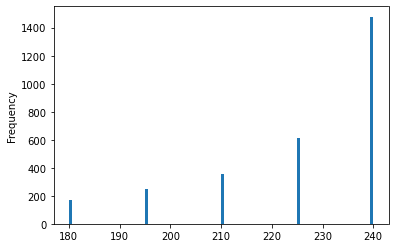

In [10]:
df2.value_counts('id_new').plot.hist(bins=100);

# FEATURE EXTRACTION WITH TSFRESH

In [11]:
ts, y = clean_data.generate_ts_y(df2)

TOO MANY PLOTS (2860). INCREASE MAX_PLOTS


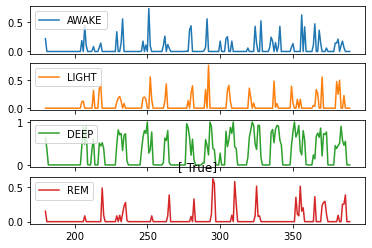

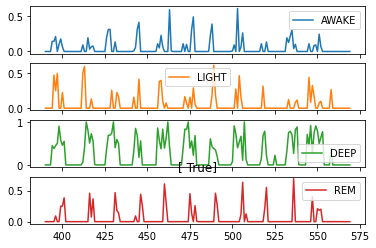

In [12]:
import matplotlib.pyplot as plt

plotting.plot_binned(df2, max_plots=2)

In [13]:
extracted_features = extract_features(ts, column_id="id_new", column_sort="index")

Feature Extraction: 100%|██████████| 20/20 [19:32<00:00, 58.62s/it]  


In [14]:
impute(extracted_features)
features_filtered = select_features(extracted_features, y)

C:\Users\Harris\anaconda3\envs\msc-thesis\lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['AWAKE__friedrich_coefficients__coeff_0__m_3__r_30'
 'AWAKE__friedrich_coefficients__coeff_1__m_3__r_30'
 'AWAKE__friedrich_coefficients__coeff_2__m_3__r_30'
 'AWAKE__friedrich_coefficients__coeff_3__m_3__r_30'
 'AWAKE__max_langevin_fixed_point__m_3__r_30'
 'AWAKE__query_similarity_count__query_None__threshold_0.0'
 'LIGHT__friedrich_coefficients__coeff_0__m_3__r_30'
 'LIGHT__friedrich_coefficients__coeff_1__m_3__r_30'
 'LIGHT__friedrich_coefficients__coeff_2__m_3__r_30'
 'LIGHT__friedrich_coefficients__coeff_3__m_3__r_30'
 'LIGHT__max_langevin_fixed_point__m_3__r_30'
 'LIGHT__query_similarity_count__query_None__threshold_0.0'
 'DEEP__friedrich_coefficients__coeff_0__m_3__r_30'
 'DEEP__friedrich_coefficients__coeff_1__m_3__r_30'
 'DEEP__friedrich_coefficients__coeff_2__m_3__r_30'
 'DEEP__friedrich_coefficients__coeff_3__m_3__r_30'
 'DEEP__max_langevin_f

Export

In [15]:
SELECTED_FEATURES_WRITE_DIR.mkdir(exist_ok=True)

In [16]:
p = SELECTED_FEATURES_WRITE_DIR/'feat_tsfresh_all.ftr'
extracted_features.columns = extracted_features.columns.astype(str)
extracted_features.reset_index().to_feather(p)

p = SELECTED_FEATURES_WRITE_DIR/'feat_tsfresh_select.ftr'
features_filtered.columns = features_filtered.columns.astype(str)
features_filtered.reset_index().to_feather(p)

In [17]:
print(f"{extracted_features.shape}, {features_filtered.shape}")

(2860, 3156), (2860, 422)


In [18]:
# end of script